### Notebook for preparing the data 

##### 1.0 Import and load  the data

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE, RandomOverSampler

from typing import Tuple

In [2]:
pd.plotting.register_matplotlib_converters()
original = pd.read_csv('../data/train.csv', index_col='PassengerId', sep=';', decimal='.', parse_dates=True, infer_datetime_format=True)

original.describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,802.000000,802.000000,802,802,646.000000,802.000000,802.000000,802,802.000000,187,801
unique,NaN,NaN,802,2,NaN,NaN,NaN,627,NaN,140,3
top,NaN,NaN,"Klaber, Mr. Herman",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,1,526,NaN,NaN,NaN,7,NaN,4,584
mean,0.377805,2.296758,NaN,NaN,30.075604,0.493766,0.374065,NaN,32.431675,NaN,NaN
std,0.485141,0.838651,NaN,NaN,14.470148,1.084719,0.781960,NaN,50.414965,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,29.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,30.923950,NaN,NaN


##### 1.1 Ticket decomposition

In [3]:
# decomposition of 'Ticket' to distinguish tickets with prefixes
def decompose_ticket(value: str) -> Tuple[str, int]:
    """Auxiliary function to decompose Ticket and retrieve its str prefix and int ticket number."""
    ticket = value.rsplit(" ", 1)
    prefix = None
    ticket_number = None
    
    # ticket can be composed of its prefix and number
    if len(ticket) > 1:
        prefix = ticket[0]
        ticket_number = int(ticket[1])
    elif ticket[0].isdigit():
        prefix = 'no_prefix'
        ticket_number = int(ticket[0])
    # there might be a ticket that does not contain a number
    else:
        prefix = ticket[0]
        
    return (prefix, ticket_number)

columns = ['Ticket_prefix', 'Ticket_number']
df = pd.DataFrame(original['Ticket'].map(decompose_ticket).values.tolist(), index=original.index, columns=columns)
data = original.join(df, how='right')
data.describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_prefix,Ticket_number
count,802.000000,802.000000,802,802,646.000000,802.000000,802.000000,802,802.000000,187,801,802,7.980000e+02
unique,NaN,NaN,802,2,NaN,NaN,NaN,627,NaN,140,3,42,NaN
top,NaN,NaN,"Klaber, Mr. Herman",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S,no_prefix,NaN
freq,NaN,NaN,1,526,NaN,NaN,NaN,7,NaN,4,584,598,NaN
mean,0.377805,2.296758,NaN,NaN,30.075604,0.493766,0.374065,NaN,32.431675,NaN,NaN,NaN,2.997980e+05
std,0.485141,0.838651,NaN,NaN,14.470148,1.084719,0.781960,NaN,50.414965,NaN,NaN,NaN,6.606853e+05
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,3.000000e+00
25%,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN,NaN,1.487900e+04
50%,0.000000,3.000000,NaN,NaN,29.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,NaN,1.120585e+05
75%,1.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,30.923950,NaN,NaN,NaN,3.470820e+05


##### 1.2 Drop columns and change type

In [4]:
sb_vars = data.select_dtypes(include='object')
data[sb_vars.columns] = data.select_dtypes(['object']).apply(lambda x: x.astype('category'))

cols_nr = data.select_dtypes(include='number')
cols_sb = data.select_dtypes(include='category')

In [5]:
# drop names, each record is unique, that is not infromative
cols_sb = cols_sb.drop('Name', axis=1)

In [6]:
# drop Cabin, 75% records is missing this value and 75% of its occurrences is unique
cols_sb = cols_sb.drop('Cabin', axis=1)

In [7]:
# drop Ticket, it was decomposed to 'Ticket_prefix' and 'Ticket_number'
cols_sb = cols_sb.drop('Ticket', axis=1)

In [8]:
# features of numeric type
cols_nr.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Ticket_number'], dtype='object')

In [9]:
# features of categoric type
cols_sb.columns

Index(['Sex', 'Embarked', 'Ticket_prefix'], dtype='object')

##### 1.3 Missing values  imputation

In [10]:
imp_nr = SimpleImputer(strategy='median', missing_values=np.nan, copy=True)
imp_sb = SimpleImputer(strategy='most_frequent', missing_values=np.nan, copy=True)
df_nr = pd.DataFrame(imp_nr.fit_transform(cols_nr), columns=cols_nr.columns)
df_sb = pd.DataFrame(imp_sb.fit_transform(cols_sb), columns=cols_sb.columns)

data = df_nr.join(df_sb, how='right')
data.describe(include='all')

,Survived,Pclass,Age,SibSp,Parch,Fare,Ticket_number,Sex,Embarked,Ticket_prefix
count,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,8.020000e+02,802,802,802
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3,42
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male,S,no_prefix
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,526,585,598
mean,0.377805,2.296758,29.866384,0.493766,0.374065,32.431675,2.988616e+05,NaN,NaN,NaN
std,0.485141,0.838651,12.991826,1.084719,0.781960,50.414965,6.591665e+05,NaN,NaN,NaN
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,3.000000e+00,NaN,NaN,NaN
25%,0.000000,2.000000,23.000000,0.000000,0.000000,7.895800,1.487900e+04,NaN,NaN,NaN
50%,0.000000,3.000000,29.000000,0.000000,0.000000,14.454200,1.120585e+05,NaN,NaN,NaN
75%,1.000000,3.000000,36.000000,1.000000,0.000000,30.923950,3.470820e+05,NaN,NaN,NaN


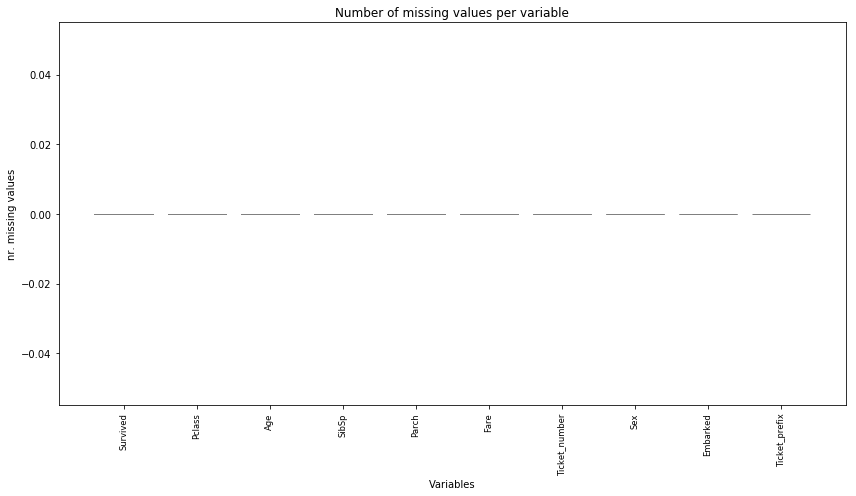

In [11]:
def bar_chart(ax: plt.axes, xvalues: list, yvalues: list, title: str, xlabel: str, ylabel: str, percentage=False):
    """Function to draw bar charts."""
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(xvalues, rotation=90, fontsize='small')
    if percentage:
        ax.set_ylim(0.0, 1.0)
    ax.bar(xvalues, yvalues, edgecolor='grey')

def plot_missing_values(data: pd.DataFrame):
    fig = plt.figure(figsize=(12,7))
    mv = {}
    for var in data:
        mv[var] = data[var].isna().sum()
        bar_chart(plt.gca(), mv.keys(), mv.values(), 'Number of missing values per variable', 'Variables', 'nr. missing values')
    fig.tight_layout()
    plt.show()
    
plot_missing_values(data)

##### 1.4 Normalization

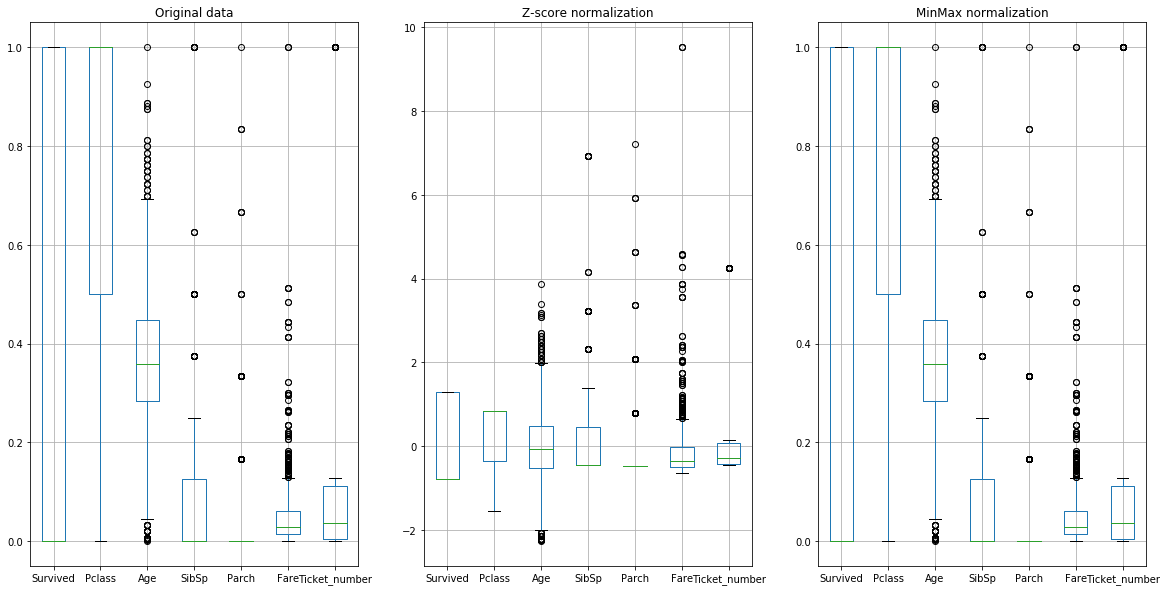

In [12]:
# Normalization, comparison of two normalization apporaches. To keep initial values of Pclass, SibSp and Parch I will use min-max

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
df_nr = pd.DataFrame(transf.transform(df_nr), columns= df_nr.columns)
norm_data_zscore = df_nr.join(df_sb, how='right')
norm_data_zscore.describe(include='all')

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
df_nr = pd.DataFrame(transf.transform(df_nr), columns= df_nr.columns)
norm_data_minmax = df_nr.join(df_sb, how='right')
norm_data_minmax.describe(include='all')


fig, axs = plt.subplots(1, 3, figsize=(20,10),squeeze=False)
axs[0, 0].set_title('Original data')
df_nr.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title('MinMax normalization')
norm_data_minmax.boxplot(ax=axs[0, 2])
#fig.tight_layout()
plt.show() 

##### 1.5 Dummification

In [37]:
# One hot encoder allows to apply dummification. 

def dummify(df, cols_to_dummify):
    one_hot_encoder = OneHotEncoder(sparse=False)
    
    for var in cols_to_dummify:
        one_hot_encoder.fit(data[var].values.reshape(-1, 1))
        feature_names = one_hot_encoder.get_feature_names([var])
        transformed_data = one_hot_encoder.transform(data[var].values.reshape(-1, 1))
        df = pd.concat((df, pd.DataFrame(transformed_data, columns=feature_names)), 1)
        df.pop(var)
    return df
  
df = dummify(data, cols_sb.columns)
df.describe(include='all')

,Survived,Pclass,Age,SibSp,Parch,Fare,Ticket_number,Sex_female,Sex_male,Embarked_C,...,Ticket_prefix_SOTON/O2,Ticket_prefix_SOTON/OQ,Ticket_prefix_STON/O 2.,Ticket_prefix_STON/O2.,Ticket_prefix_SW/PP,Ticket_prefix_W./C.,Ticket_prefix_W.E.P.,Ticket_prefix_W/C,Ticket_prefix_WE/P,Ticket_prefix_no_prefix
count,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,8.020000e+02,802.000000,802.000000,802.000000,...,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000
mean,0.377805,2.296758,29.866384,0.493766,0.374065,32.431675,2.988616e+05,0.344140,0.655860,0.185786,...,0.002494,0.007481,0.014963,0.006234,0.001247,0.009975,0.001247,0.001247,0.002494,0.745636
std,0.485141,0.838651,12.991826,1.084719,0.781960,50.414965,6.591665e+05,0.475383,0.475383,0.389176,...,0.049906,0.086224,0.121479,0.078761,0.035311,0.099438,0.035311,0.035311,0.049906,0.435775
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,3.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,23.000000,0.000000,0.000000,7.895800,1.487900e+04,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,29.000000,0.000000,0.000000,14.454200,1.120585e+05,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,36.000000,1.000000,0.000000,30.923950,3.470820e+05,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,3.101317e+06,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


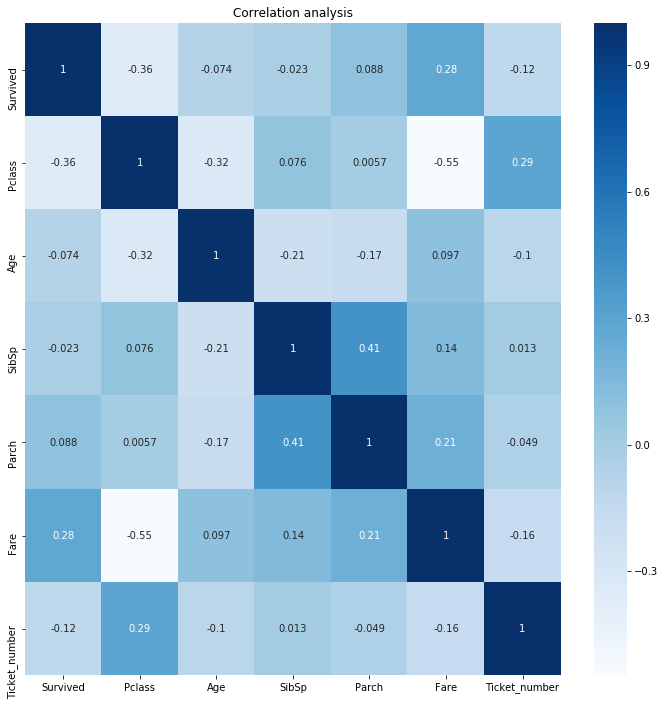

In [20]:
# correlation analysis to define and get rid of most correleated features
fig = plt.figure(figsize=[12, 12])
corr_mtx = data.corr()
sns.heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True, cmap='Blues')
plt.title('Correlation analysis')
plt.show()

##### Comments
- hetamap before dummification does not present that many information
- it is noticable that probability to survive is higher for higher Fare 
- additionaly, lower class was receiving higher ticket numbers 

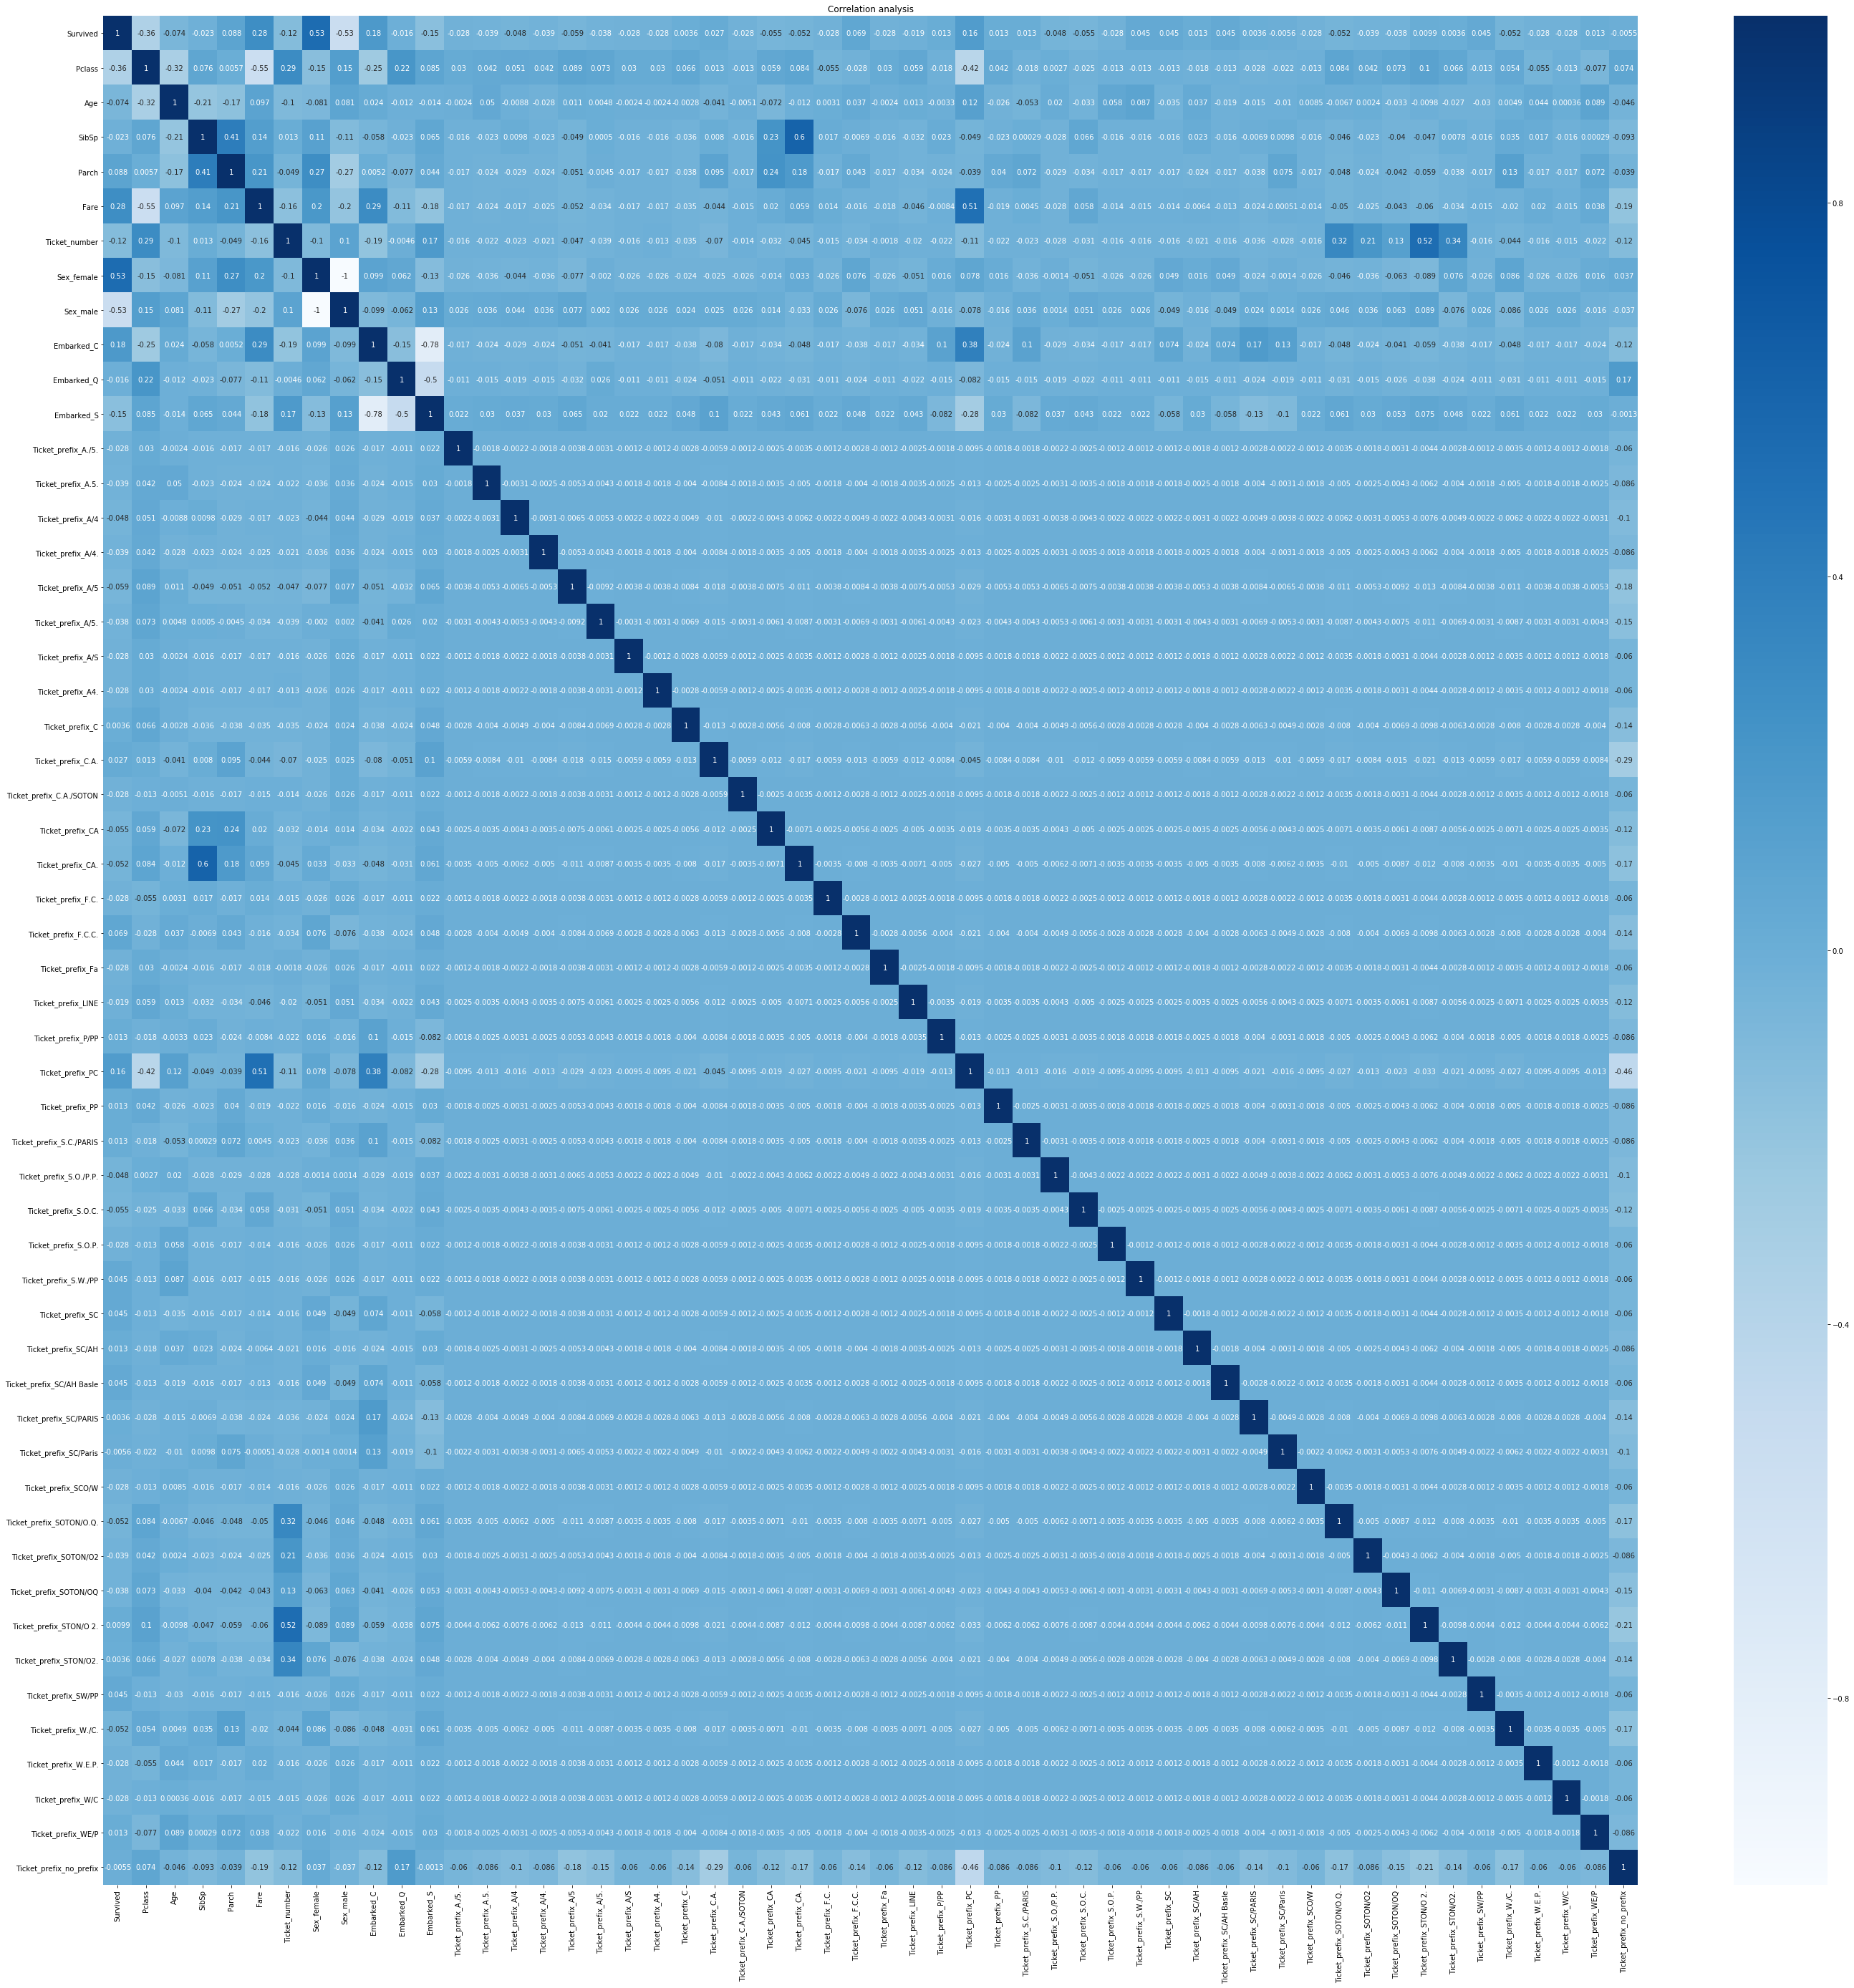

In [21]:
# correlation analysis to define and get rid of most correleated features
fig = plt.figure(figsize=[48, 48])
corr_mtx = df.corr()
sns.heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True, cmap='Blues')
plt.title('Correlation analysis')
plt.show()

##### Comments 
- heatmap above allows to compare correlation after dummification 
- female are much more likely to be saved :) 
- there are higher changes of being saved for owners of tickets with prefixes 'STONO', 'PC' or 'CA'. 

##### 1.6 Data balancing

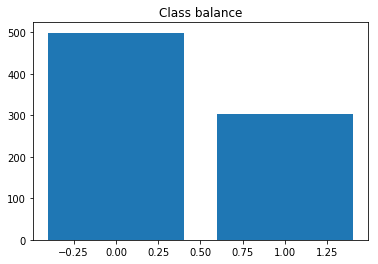

Minority class: 303
Majority class: 499
Proportion: 0.61 : 1


In [22]:
# investigate class balance

target_count = data['Survived'].value_counts()
plt.figure()
plt.title('Class balance')
plt.bar(target_count.index, target_count.values)
plt.show()

min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

print('Minority class:', target_count[ind_min_class])
print('Majority class:', target_count[1-ind_min_class])
print('Proportion:', round(target_count[ind_min_class] / target_count[1-ind_min_class], 2), ': 1')

##### Comments:
- we have smaller presence of positive records so we need to apply oversampling strategy
- after using SMOTE, the quantity of records for both classes would be 499 each 

In [38]:
RANDOM_STATE = 42

smote = SMOTE(ratio='minority', random_state=RANDOM_STATE)
y = df.pop('Survived').values
X = df.values
smote_x, smote_y = smote.fit_sample(X, y)
smote_target_count = pd.Series(smote_y).value_counts()

C:\Users\HP\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [42]:
smote_target_count

1.0    499
0.0    499
dtype: int64